In [1]:
import sys
import os
import pandas as pd
import numpy as np
import cv2 as cv
import numpy as np
import roifile
import matplotlib.pyplot as plt
from skimage import io
import matplotlib.pyplot as plt

## Nathan's 3 anotated images ussed. labels are fined in this version.

In [2]:
def convert_roi_to_label(label, rois):
    print("label shape: ", label.shape)
    print("no of unique labels: ", len(rois))

    for i in range(0, len(rois)):
        coord = rois[i].integer_coordinates
        top = rois[i].top
        left = rois[i].left
        coord[:, 0] = coord[:, 0] + left
        coord[:, 1] = coord[:, 1] + top

        contour = []
        for j in range(0, len(coord)):
            contour.append([ coord[j][0], coord[j][1] ])

        contour = np.asarray(coord).astype(np.int32)
        # cv.drawContours(img, [contour], -1, (0,255,0), 1)
        # cv.drawContours(label, [contour], -1, (i), 1)
        cv.fillPoly(label, pts=[contour], color=i)

In [3]:
def percentile_normalization(image, pmin=1, pmax=98, clip = False):
    # Normalize the image using percentiles
    lo, hi = np.percentile(image, (pmin, pmax))
    image_norm_percentile = (image - lo) / (hi - lo)
    
    if clip:
        image_norm_percentile[image_norm_percentile>1] = 1
        image_norm_percentile[image_norm_percentile<0] = 0
        
    return image_norm_percentile

In [4]:
def fix_label(label):
    
    u = np.unique(label)
    v = label.copy()

    for i in range(0, v.shape[0]):
        for j in range(0, v.shape[1]):
            v[i][j] = np.where(u == v[i][j])[0]

    return v


label shape:  (800, 800)
no of unique labels:  1678


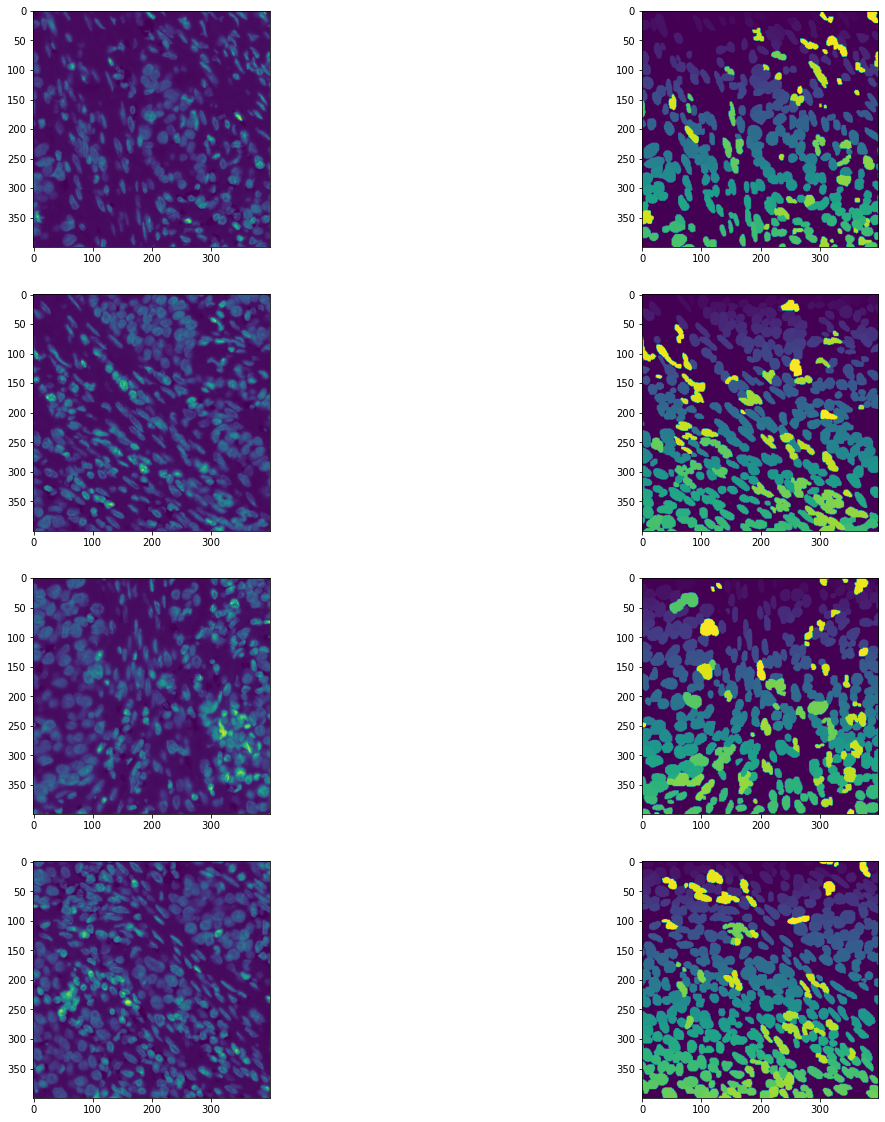

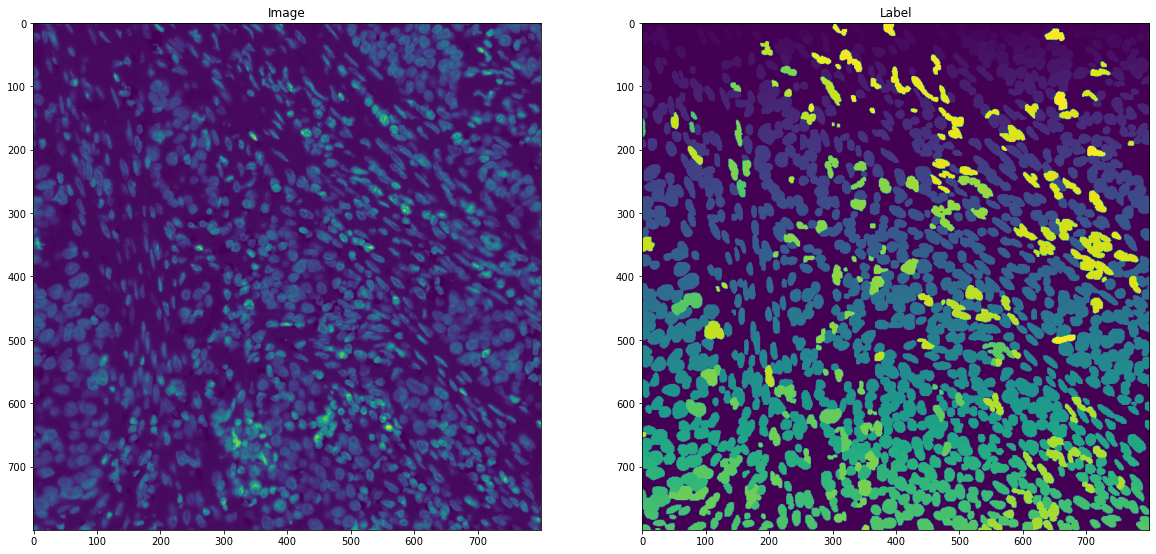

label shape:  (800, 800)
no of unique labels:  1835


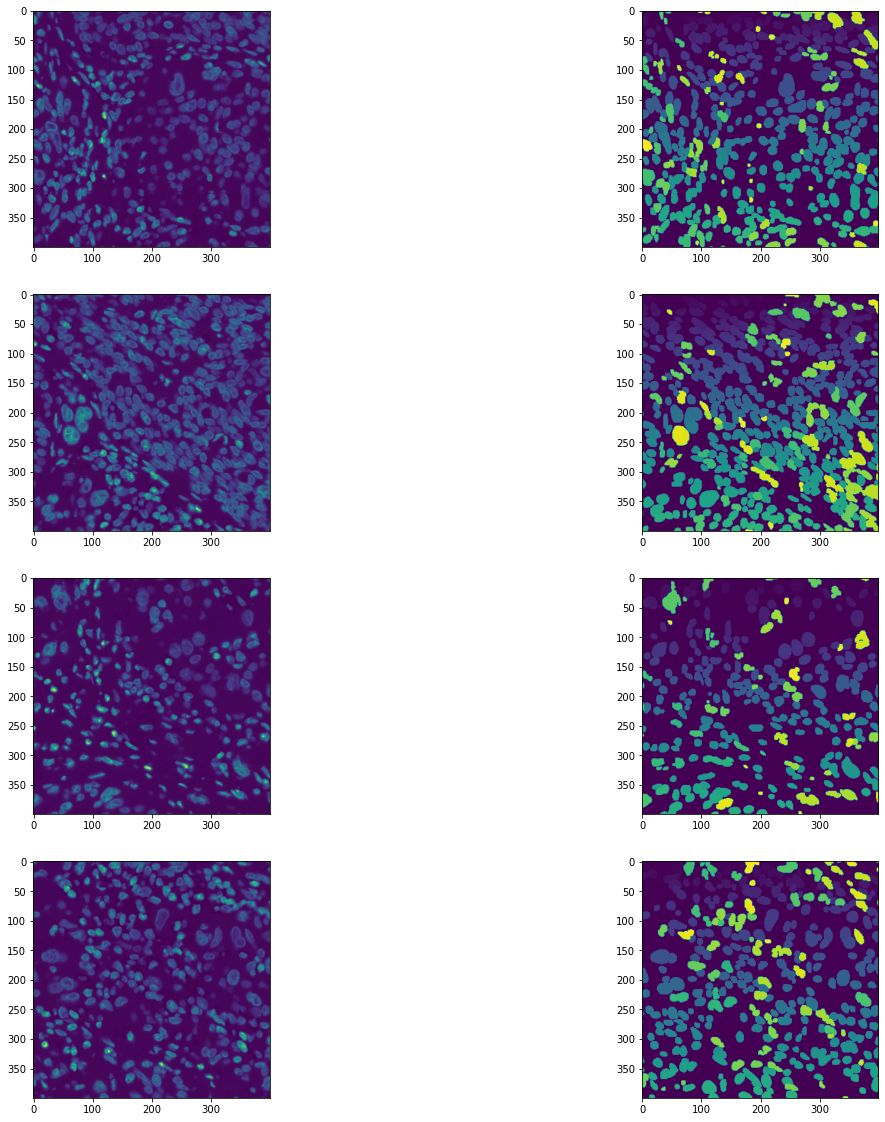

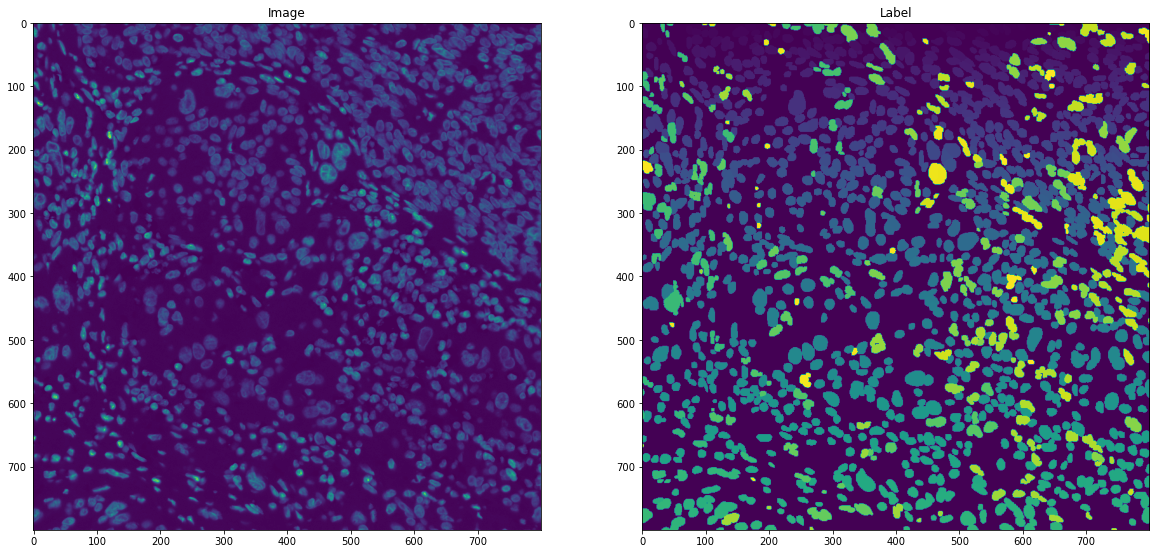

label shape:  (800, 800)
no of unique labels:  2194


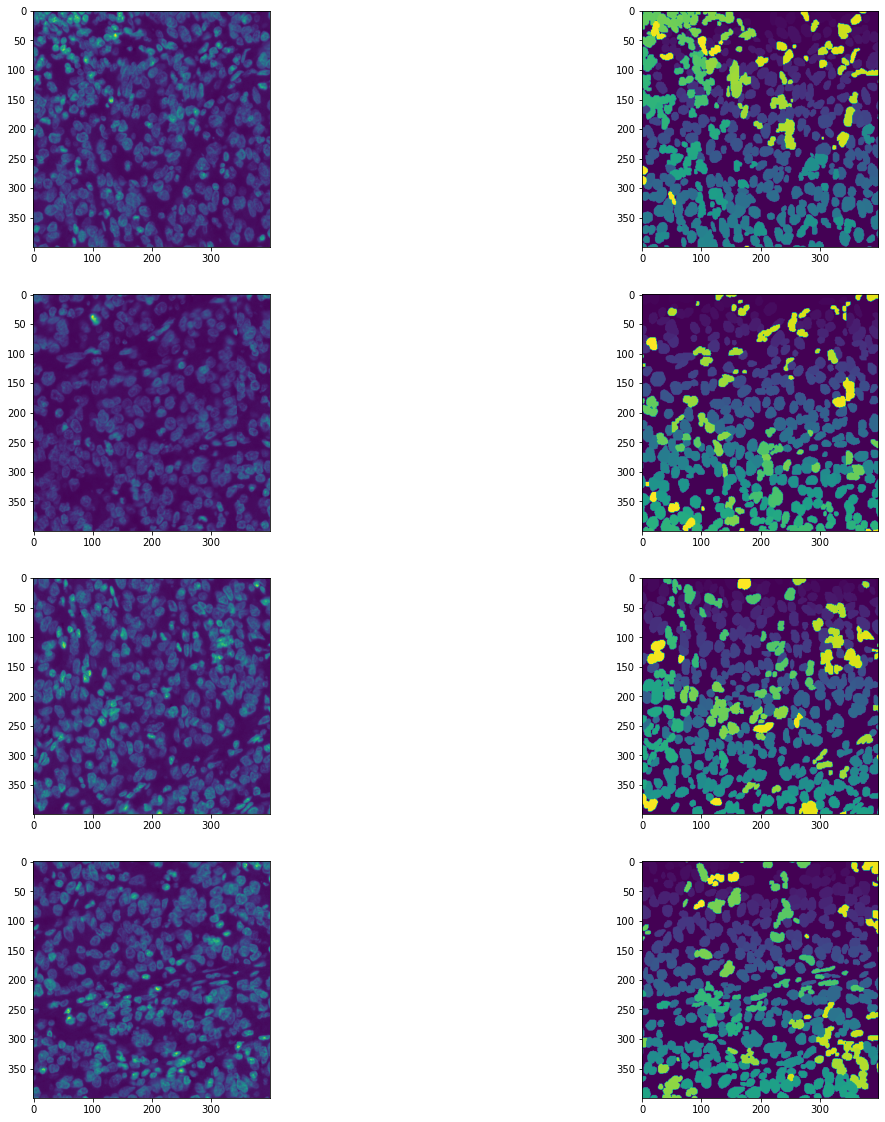

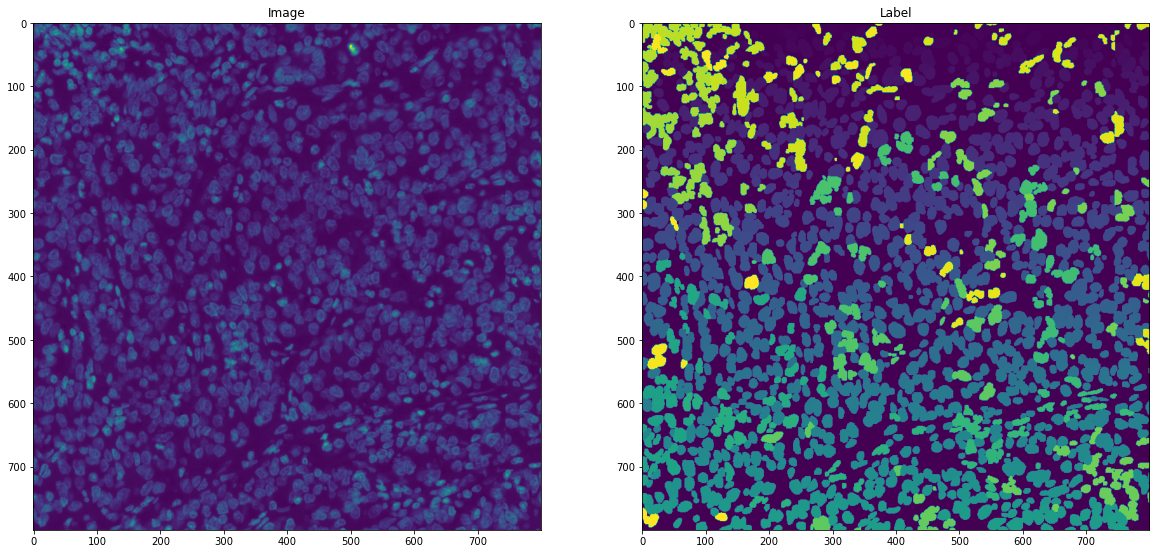

label shape:  (800, 800)
no of unique labels:  2075


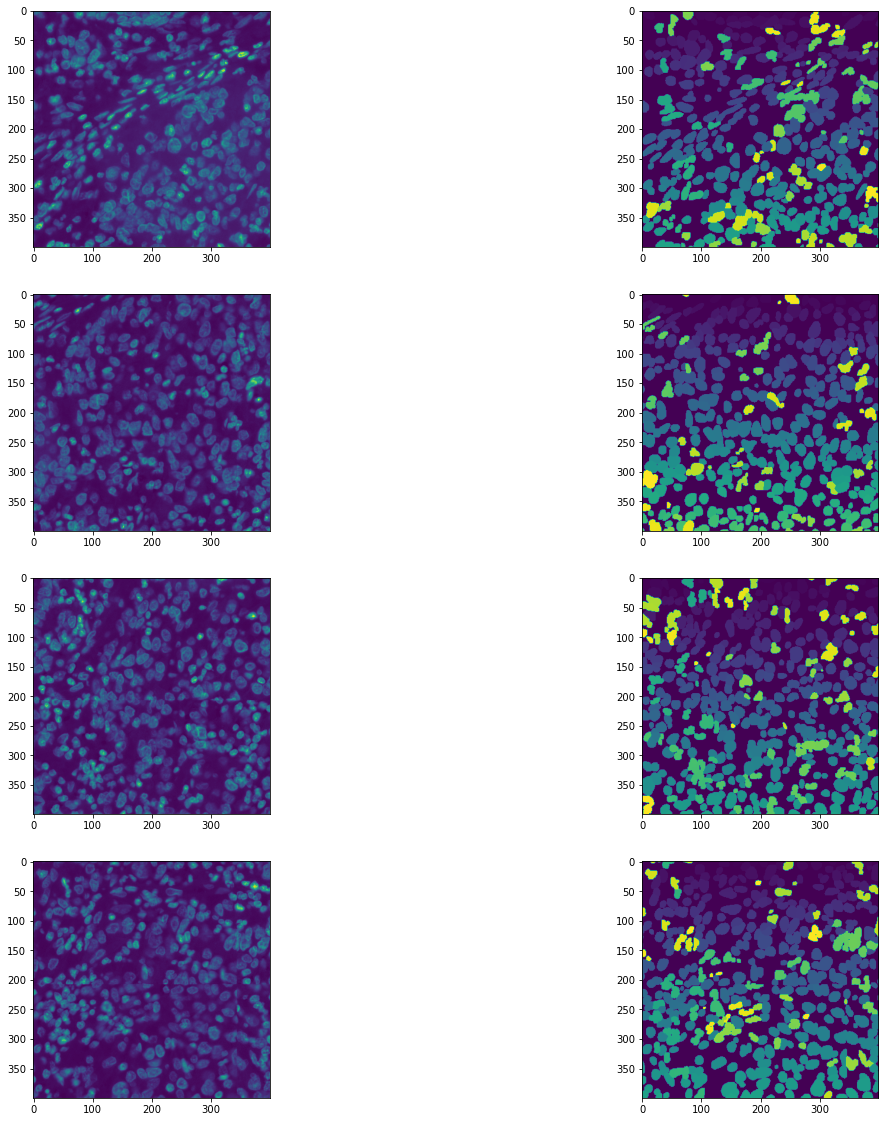

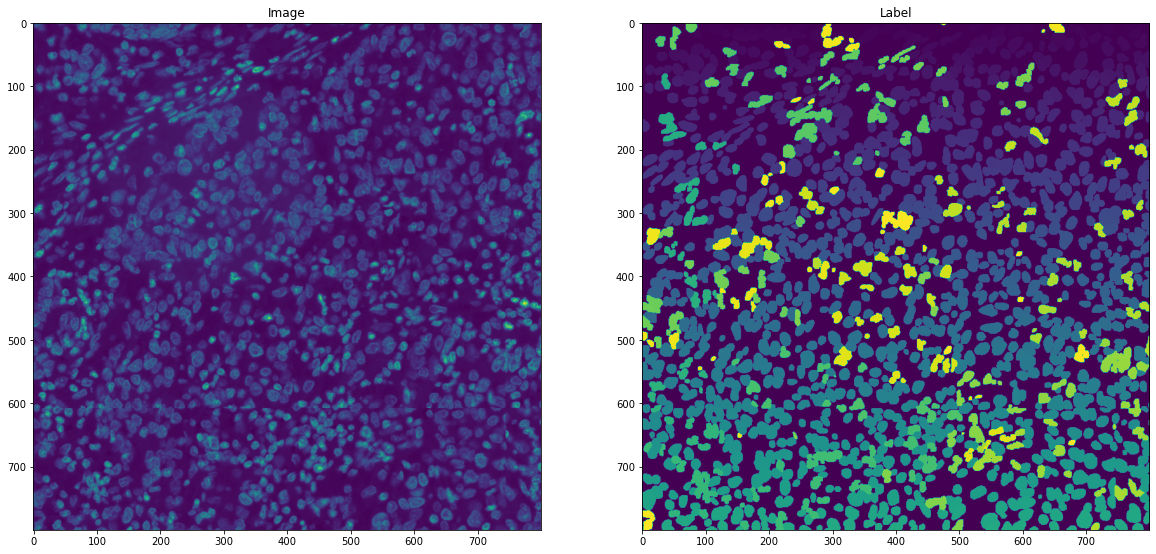

label shape:  (400, 400)
no of unique labels:  596


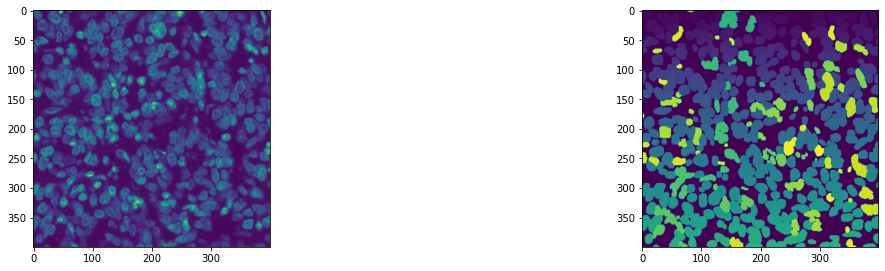

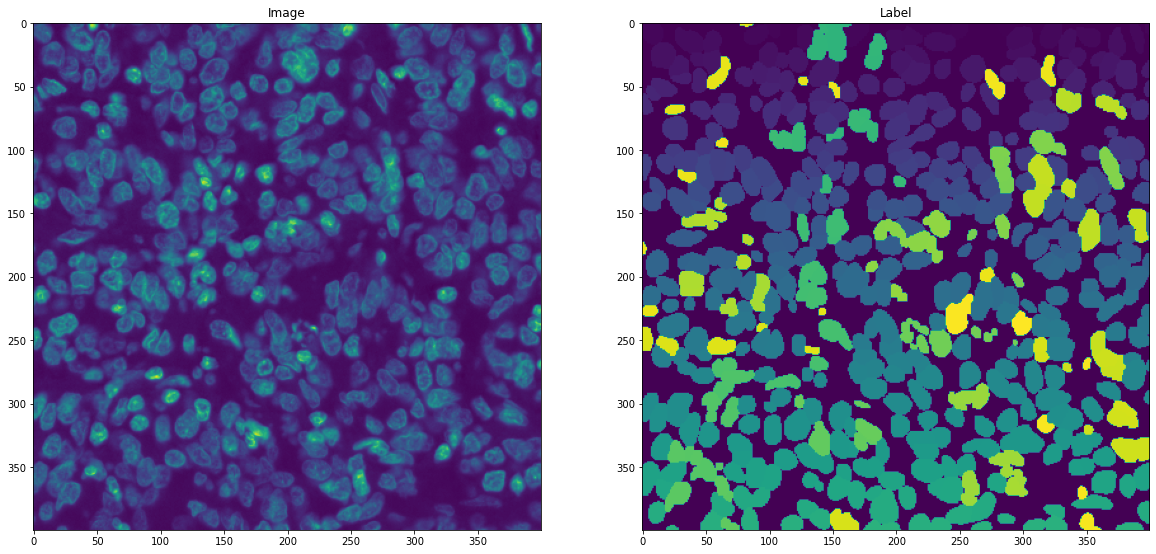

In [5]:
img_names = ['19568[58086,9988]1200,700-Crop_Dapi_',
             '28787[53555,12945]400,700-Crop_Dapi_',
             '49017[47150,16615]600,0-Crop_Dapi_',
             '49017[48973,16424]600,400-Crop_Dapi_',
             '49017[47150,16615]1600,0-Crop_Dapi_' # image size = 400x400
             ]

data_dir = "/nadeem_lab/Gunjan/combined_analysis/"

for k in range(len(img_names)):

    img = np.array(io.imread(data_dir + img_names[k] + 'Png.png')).astype('float32')
    # print("img1 shape", img.shape, img_names[k])

    ch_number = np.mean(img)
    # print("ch_number : ", ch_number)

    img = percentile_normalization(img, pmin=1, pmax=98, clip = False)

    ch_number = np.mean(img)
    # print("ch_number : ", ch_number)
    
    filename_nathan = data_dir + img_names[k] + 'Mask_Roi_Zip.zip'

    out_nathan = roifile.roiread(filename_nathan)
    label_nathan = np.zeros((img.shape[0], img.shape[1])).astype(np.int32)
    convert_roi_to_label(label_nathan, out_nathan )

    m = 400

    patch_org = np.zeros((m, m))
    patch_lab = np.zeros((m, m))

    plt.figure(figsize=(20, 20))
    count = 0
    patch_num = 0 
    ps = int(img.shape[0]/m)

    for i in range (0, ps):
        for j in range (0, ps):
            count = count + 1
            patch_num = patch_num + 1
            patch_org = img[i * m : i * m + m,  j * m : j * m + m]
            patch_lab = label_nathan[i * m : i * m + m,  j * m : j * m + m]
            
            # print("patch_lab shape: ", patch_lab.shape, np.unique(patch_lab), len(np.unique(patch_lab)), np.max(patch_lab))
            
            patch_lab = fix_label(patch_lab)

            # print("patch_lab2 shape: ", patch_lab.shape, np.unique(patch_lab), len(np.unique(patch_lab)), np.max(patch_lab))

            plt.subplot(4, 2, count)
            plt.imshow(patch_org)
            
            count = count + 1
            plt.subplot(4, 2, count)
            plt.imshow(patch_lab)

            # np.savez('/nadeem_lab/Gunjan/data/impartial/DAPI1CH_v2/' + 'image_' + str(k) + '_patch_' + str(patch_num) + '.npz', image = patch_org, label = patch_lab)

    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.title("Image")
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.title("Label")
    plt.imshow(label_nathan)
    plt.show()

    # break
    


In [12]:
# savedir = '/nadeem_lab/Gunjan/combined_analysis/DAPI1CH/'
savedir = '/nadeem_lab/Gunjan/data/impartial/DAPI1CH_v2/'
train_list = [0,1,2,3,4]

In [13]:
row_list = []
# prefix     input_file  group
for i in train_list:
    for j in range(1,5):
        if i == 4 and j == 2:
            break
        npz_read = np.load(savedir + 'image_' + str(i) + '_patch_' + str(j) + '.npz')

        group = 'train'
        row_list.append(['image_' + str(i) + '_patch_' + str(j), 'image_' + str(i) + '_patch_' + str(j) + '.npz', group])

In [14]:
pd_files = pd.DataFrame(data = row_list, columns = ['prefix', 'input_file','group'])

In [15]:
pd_files.to_csv(savedir + 'files.csv')

In [16]:
pd_files

prefix           input_file  group
0   image_0_patch_1  image_0_patch_1.npz  train
1   image_0_patch_2  image_0_patch_2.npz  train
2   image_0_patch_3  image_0_patch_3.npz  train
3   image_0_patch_4  image_0_patch_4.npz  train
4   image_1_patch_1  image_1_patch_1.npz  train
5   image_1_patch_2  image_1_patch_2.npz  train
6   image_1_patch_3  image_1_patch_3.npz  train
7   image_1_patch_4  image_1_patch_4.npz  train
8   image_2_patch_1  image_2_patch_1.npz  train
9   image_2_patch_2  image_2_patch_2.npz  train
10  image_2_patch_3  image_2_patch_3.npz  train
11  image_2_patch_4  image_2_patch_4.npz  train
12  image_3_patch_1  image_3_patch_1.npz  train
13  image_3_patch_2  image_3_patch_2.npz  train
14  image_3_patch_3  image_3_patch_3.npz  train
15  image_3_patch_4  image_3_patch_4.npz  train
16  image_4_patch_1  image_4_patch_1.npz  train